## Exp 2: a validation script for Exp 2
### Result:
#### If learn 0, 1, 2, 3, 4, 5, 6, all larger will be classified as 6 (no ability to learn more than 6 a.k.a unseen data)
#### If learn 1,3, 5, 7, 9, all in between value will be casted to the closest value (also unable to learn unseen data)


In [1]:
from __future__ import print_function
from __future__ import absolute_import
import matplotlib.pyplot as plt

import sugartensor as tf
import os
from IPython.display import display, Image
import numpy as np
from scipy import ndimage
from six.moves import cPickle as pickle

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"
%matplotlib inline


In [2]:
batch_size = 64   # batch size
image_size = 32
pixel_depth = 255.0

## Validation data

3000
[8 1 7 1]
Tensor("train_1:1", shape=(64,), dtype=int64)
Tensor("train_1:0", shape=(64, 32, 32, 1), dtype=float32)


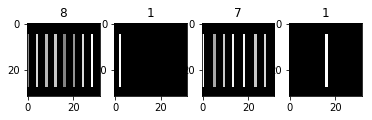

In [3]:
dir= "barcode/valid/"
fn = os.listdir(dir)
total = len(fn)
total
valid_label = np.ndarray(shape = (total), dtype = np.int64)
valid_dataset = np.ndarray(shape = (total, image_size, image_size, 1), dtype = np.float32)
counter = 0
for file in fn:
    image_data = (ndimage.imread(dir+file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
    if True:
        valid_label[counter] = int(file[0])
        valid_dataset[counter, :, :] = image_data[:,:,0].reshape(image_size, image_size, 1)
        counter+=1
print(len(valid_label))

_, axs = plt.subplots(1, 4)

label = valid_label[:4]
image = valid_dataset[:4]
print(label)
for i in range(4):
    axs[i].imshow(image[i].reshape(image_size, image_size), cmap=plt.cm.Greys);
    axs[i].set_title(label[i])

valid_image, valid_label = tf.sg_data._data_to_tensor([valid_dataset, valid_label], batch_size, name = "train")

print(valid_label)
print(valid_image)

INFO:tensorflow:Restoring parameters from asset/train/exp2.1-classifier/model.ckpt-23419
[[  4.98530035e-08   3.68478456e-29   6.06856574e-08   7.87542647e-17
    2.82001960e-08   9.99985695e-01   2.29101182e-08   1.40852080e-05
    4.67443044e-08   1.91516609e-22]
 [  1.98035350e-15   0.00000000e+00   6.76857633e-15   8.38202091e-38
    1.94175275e-16   2.82439810e-35   4.83847983e-16   1.43608123e-01
    2.74258601e-16   8.56391847e-01]
 [  4.47662037e-15   0.00000000e+00   1.24964355e-14   9.10984300e-38
    3.39243180e-16   1.00164103e-34   9.71303586e-16   3.98202300e-01
    5.34662125e-16   6.01797640e-01]
 [  2.01924248e-19   1.75183453e-18   1.95170409e-19   1.00000000e+00
    1.43532445e-19   2.59837514e-17   1.24547758e-18   0.00000000e+00
    5.64128492e-19   0.00000000e+00]
 [  5.47986906e-16   0.00000000e+00   1.42810930e-15   0.00000000e+00
    2.87713104e-17   5.16271268e-37   1.04862785e-16   7.39883333e-02
    5.16404489e-17   9.26011622e-01]]


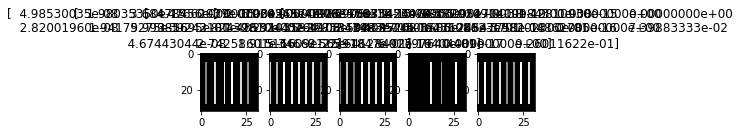

In [4]:
random_index = 10
num_sample = 5
image = tf.convert_to_tensor(valid_dataset[random_index:random_index+num_sample])

with tf.sg_context(name='discriminator', size=4, stride=2, act='leaky_relu'):
        
        # shared part
        # have to set batch norm at the layer level because we dont want to use batch norm everywhere
        logit = (image
                  .sg_conv(dim=64, name = 'conv2', bn = True)
                  .sg_conv(dim=128, name='conv3', bn = True)
                  .sg_flatten()
                  .sg_dense(dim=1024, name='fc1')
                  .sg_dense(dim=10, act='linear', name = 'cat')
                 .sg_softmax())

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.1)

sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
with sess:

    tf.sg_init(sess)

    # restore parameters
    tf.sg_restore(sess, tf.train.latest_checkpoint('asset/train/exp2.1-classifier'), category='discriminator')

    # run generator
    labels = sess.run(logit)

_, axs = plt.subplots(1, num_sample)              

print(labels)

for i in range(num_sample):
    axs[i].imshow(valid_dataset[random_index+i].reshape(image_size, image_size), cmap=plt.cm.Greys)
    axs[i].set_title(labels[i])